In [27]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

symbols = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA"]

data = {}
for sym in symbols:
    data[sym] = yf.download(sym, start="2018-01-01", end="2025-01-01")

print(data["AAPL"].head())

/tmp/ipython-input-194/192627604.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data[sym] = yf.download(sym, start="2018-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-194/192627604.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data[sym] = yf.download(sym, start="2018-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-194/192627604.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data[sym] = yf.download(sym, start="2018-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-194/192627604.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data[sym] = yf.download(sym, start="2018-01-01", end="2025-01-01")
[*********************100%***********************

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2018-01-02  40.304176  40.313537  39.602258  39.812835  102223600
2018-01-03  40.297146  40.839965  40.233976  40.367338  118071600
2018-01-04  40.484329  40.587278  40.262056  40.369681   89738400
2018-01-05  40.945259  41.031828  40.489013  40.580262   94640000
2018-01-08  40.793175  41.087979  40.694903  40.793175   82271200


In [28]:
for sym in symbols:
    df = data[sym]
    df["returns"] = df["Close"].pct_change()
    data[sym] = df.dropna()

In [29]:
for sym in symbols:
    df = data[sym]
    df["target"] = df["Close"].shift(-1)
    data[sym] = df.dropna()


In [30]:
from sklearn.metrics import mean_absolute_error

for sym in symbols:
    df = data[sym]
    mae = mean_absolute_error(df["target"], df["Close"])
    print(f"{sym} baseline MAE:", round(mae, 3))

AAPL baseline MAE: 1.571
MSFT baseline MAE: 2.891
GOOGL baseline MAE: 1.373
AMZN baseline MAE: 1.961
NVDA baseline MAE: 0.69


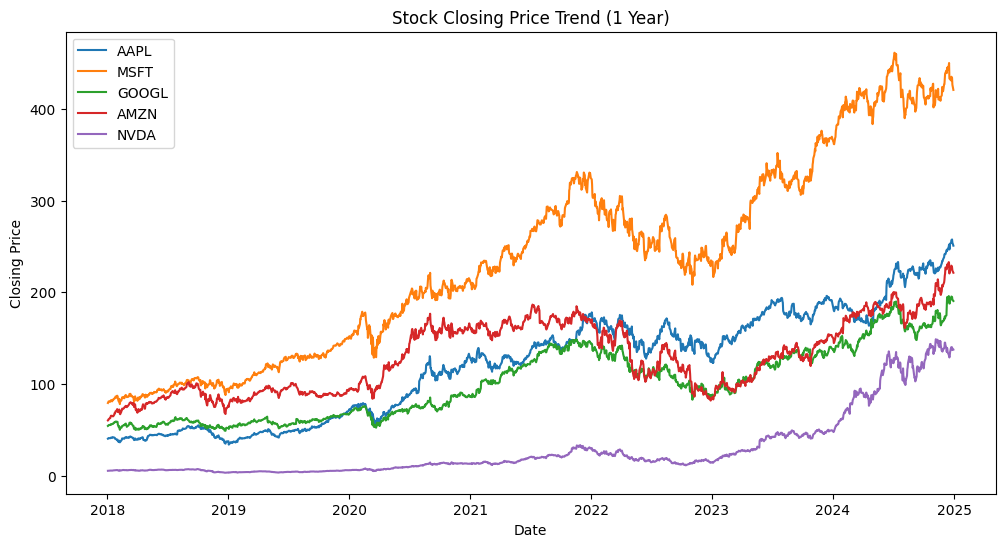

In [31]:
# Closing Price Trend (Time Series)

plt.figure(figsize=(12, 6))

for sym in symbols:
    plt.plot(data[sym].index, data[sym]["Close"], label=sym)

plt.title("Stock Closing Price Trend (1 Year)")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

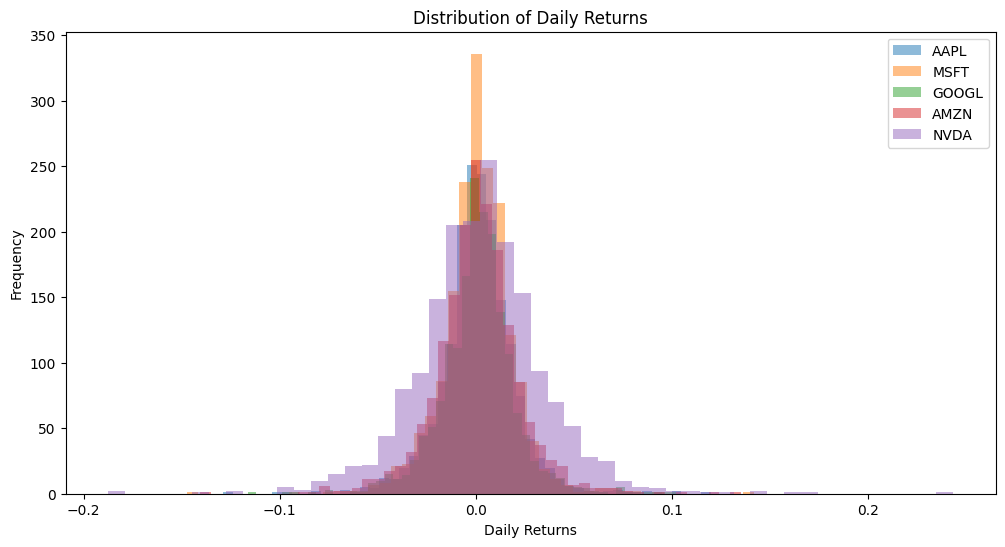

In [32]:
# Daily Returns Distribution (Risk Visualization)

plt.figure(figsize=(12, 6))

for sym in symbols:
    returns = data[sym]["Close"].pct_change()
    plt.hist(returns.dropna(), bins=50, alpha=0.5, label=sym)

plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Returns")
plt.ylabel("Frequency")
plt.legend()
plt.show()

/tmp/ipython-input-194/531149832.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volatility.append(float(vol))
/tmp/ipython-input-194/531149832.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volatility.append(float(vol))
/tmp/ipython-input-194/531149832.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volatility.append(float(vol))
/tmp/ipython-input-194/531149832.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volatility.append(float(vol))
/tmp/ipython-input-194/531149832.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the f

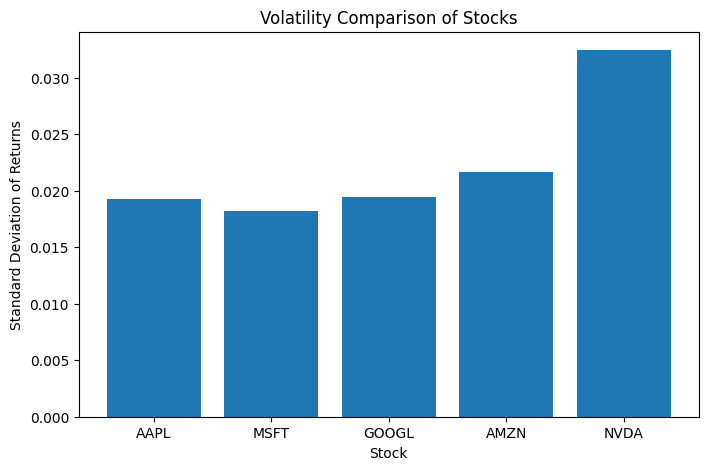

In [33]:
# Volatility Comparison (Bar Chart)

volatility = []

for sym in symbols:
    vol = data[sym]["Close"].pct_change().dropna().std()
    volatility.append(float(vol))

vol_df = pd.DataFrame({
    "Stock": symbols,
    "Volatility": volatility
})

plt.figure(figsize=(8, 5))
plt.bar(vol_df["Stock"].values, vol_df["Volatility"].values)
plt.title("Volatility Comparison of Stocks")
plt.xlabel("Stock")
plt.ylabel("Standard Deviation of Returns")
plt.show()

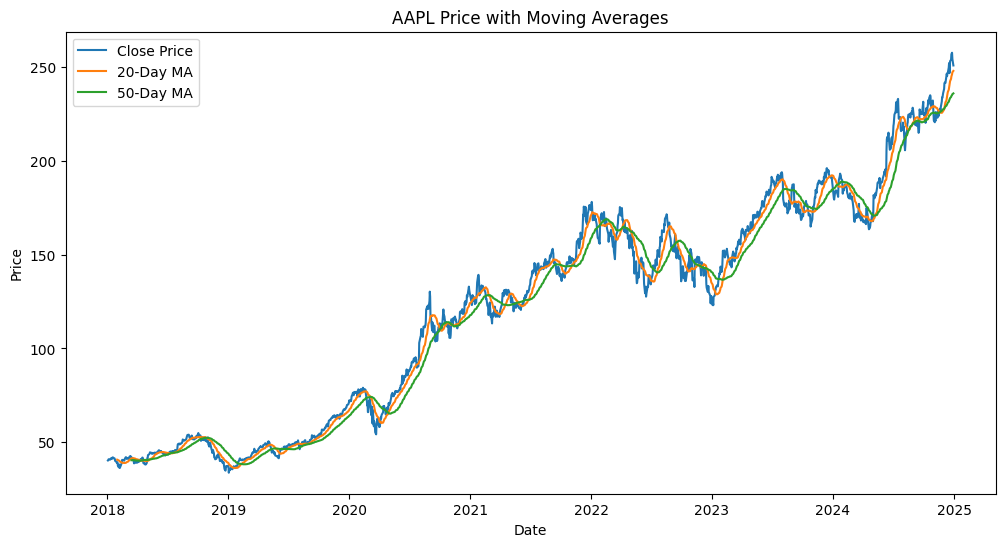

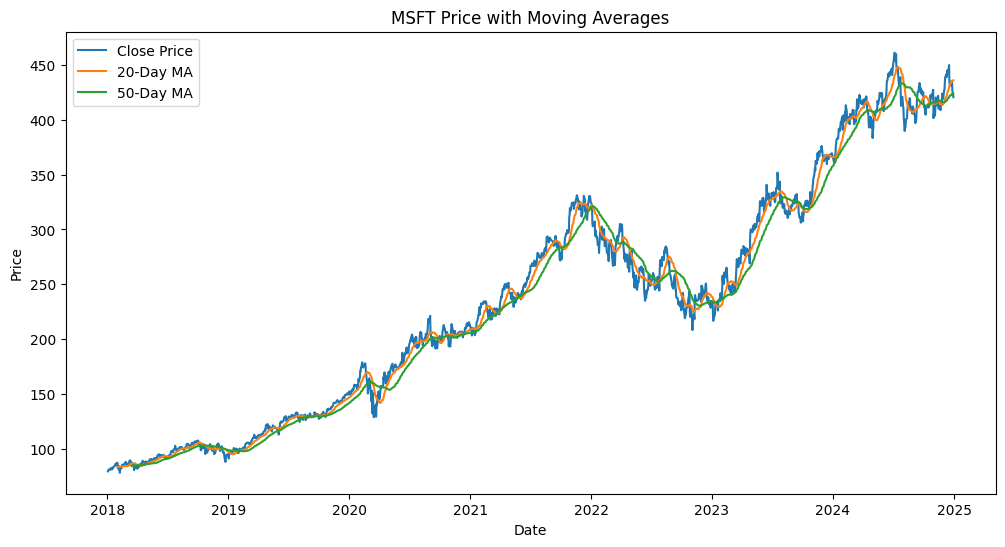

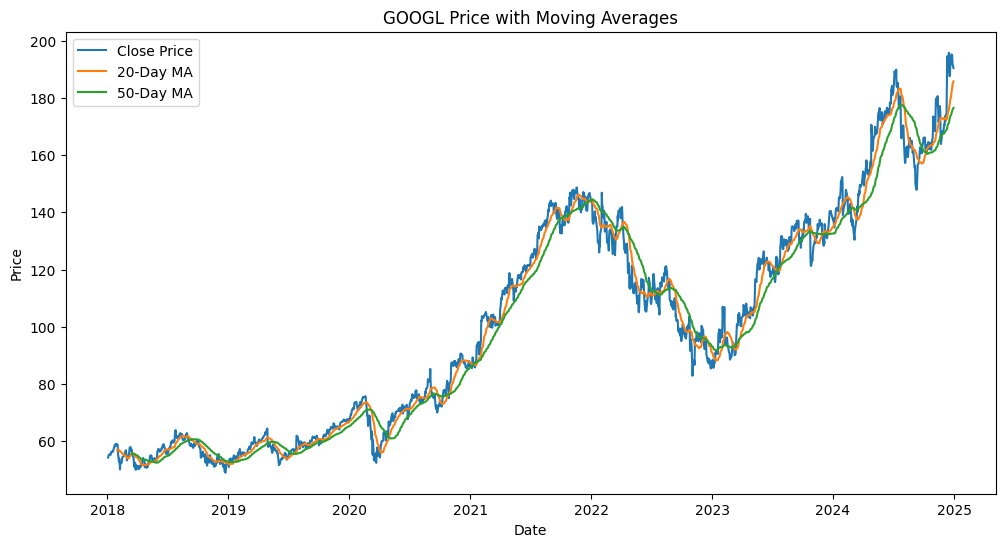

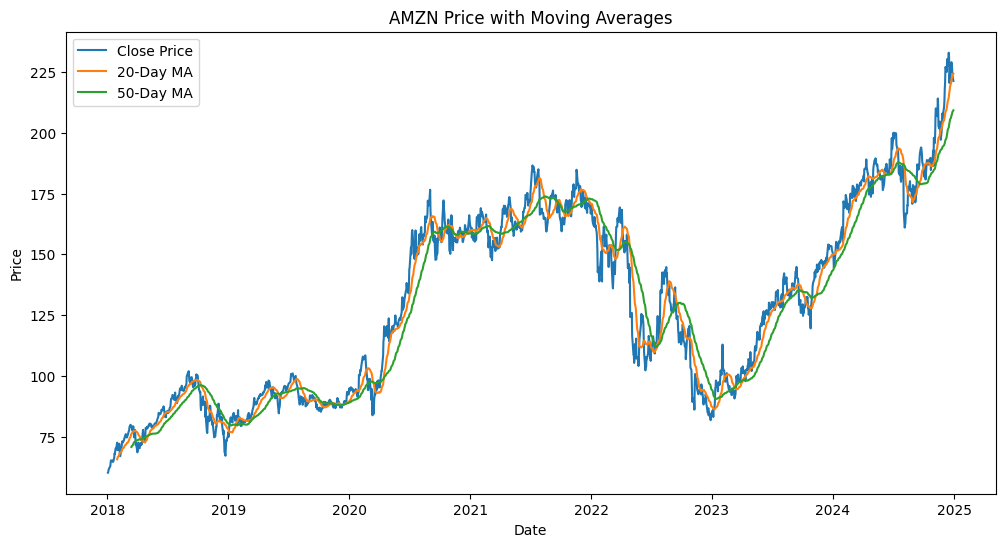

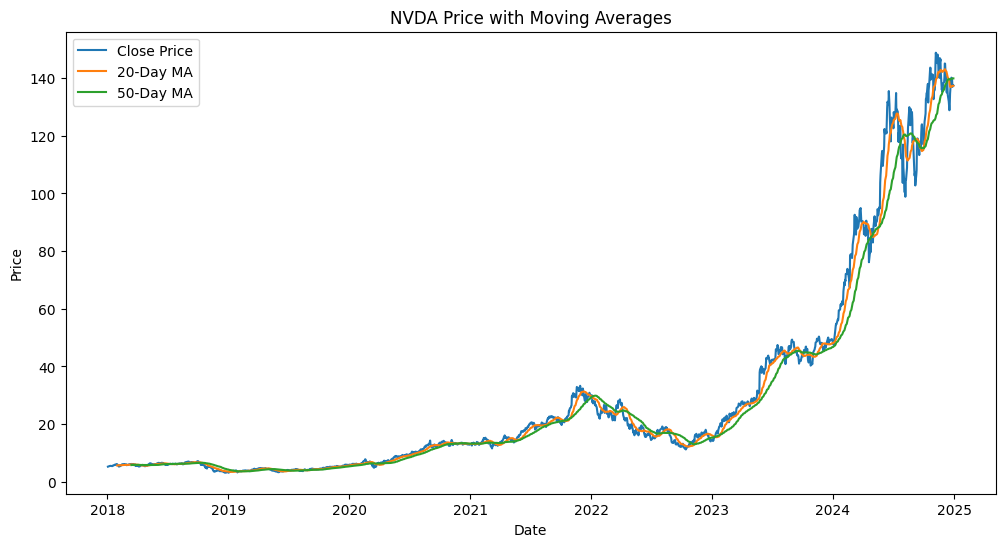

In [34]:
# Moving Averages (Trend Strength)

window_short = 20
window_long = 50

for sym in symbols:
    df = data[sym].copy()
    df["MA20"] = df["Close"].rolling(window_short).mean()
    df["MA50"] = df["Close"].rolling(window_long).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df["Close"], label="Close Price")
    plt.plot(df.index, df["MA20"], label="20-Day MA")
    plt.plot(df.index, df["MA50"], label="50-Day MA")
    plt.title(f"{sym} Price with Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

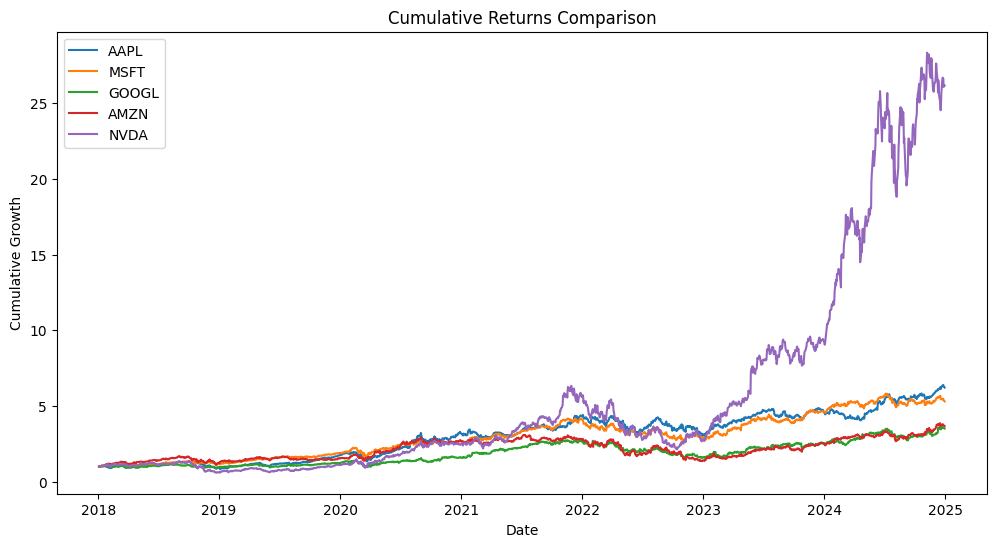

In [35]:
# Cumulative Returns (Performance Comparison)

plt.figure(figsize=(12, 6))

for sym in symbols:
    returns = data[sym]["Close"].pct_change()
    cumulative_returns = (1 + returns).cumprod()
    plt.plot(cumulative_returns, label=sym)

plt.title("Cumulative Returns Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Growth")
plt.legend()
plt.show()

In [36]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense

from statsmodels.tsa.arima.model import ARIMA

In [37]:
def create_sequences(series, window_size=60):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

def evaluate(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = math.sqrt(mean_squared_error(true, pred))
    mape = np.mean(np.abs((true - pred) / true)) * 100
    return mae, rmse, mape

In [38]:
window_size = 60

for sym in symbols:
    print(f"\n===== {sym} Deep Learning Models =====")

    df = data[sym]
    prices = df["Close"].values.reshape(-1, 1)

    # Scale
    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)

    # Create sequences
    X, y = create_sequences(scaled_prices, window_size)

    # Time-series split (NO SHUFFLE)
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # ---------------- LSTM ----------------
    lstm_model = Sequential([
        LSTM(50, input_shape=(window_size, 1)),
        Dense(1)
    ])

    lstm_model.compile(optimizer="adam", loss="mse")
    lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

    lstm_pred_scaled = lstm_model.predict(X_test)
    lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
    y_test_actual = scaler.inverse_transform(y_test)

    lstm_mae, lstm_rmse, lstm_mape = evaluate(y_test_actual, lstm_pred)

    print("LSTM Results:")
    print(f"MAE  : {lstm_mae:.3f}")
    print(f"RMSE : {lstm_rmse:.3f}")
    print(f"MAPE : {lstm_mape:.2f}%")

    # ---------------- GRU ----------------
    gru_model = Sequential([
        GRU(50, input_shape=(window_size, 1)),
        Dense(1)
    ])

    gru_model.compile(optimizer="adam", loss="mse")
    gru_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

    gru_pred_scaled = gru_model.predict(X_test)
    gru_pred = scaler.inverse_transform(gru_pred_scaled)

    gru_mae, gru_rmse, gru_mape = evaluate(y_test_actual, gru_pred)

    print("\nGRU Results:")
    print(f"MAE  : {gru_mae:.3f}")
    print(f"RMSE : {gru_rmse:.3f}")
    print(f"MAPE : {gru_mape:.2f}%")


===== AAPL Deep Learning Models =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
LSTM Results:
MAE  : 4.713
RMSE : 5.881
MAPE : 2.34%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

GRU Results:
MAE  : 2.989
RMSE : 3.828
MAPE : 1.52%

===== MSFT Deep Learning Models =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
LSTM Results:
MAE  : 8.314
RMSE : 10.194
MAPE : 2.09%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

GRU Results:
MAE  : 5.189
RMSE : 6.699
MAPE : 1.32%

===== GOOGL Deep Learning Models =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
LSTM Results:
MAE  : 3.666
RMSE : 4.979
MAPE : 2.38%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

GRU Results:
MAE  : 2.794
RMSE : 3.740
MAPE : 1.81%

===== AMZN Deep Learning Models =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
LSTM Results:
MAE  : 4.457
RMSE : 5.646
MAPE : 2.58%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

GRU Results:
MAE  : 3.001
RMSE : 3.962
MAPE : 1.76%

===== NVDA Deep Learning Models =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
LSTM Results:
MAE  : 3.782
RMSE : 5.076
MAPE : 4.17%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

GRU Results:
MAE  : 3.076
RMSE : 4.207
MAPE : 3.28%


In [39]:
for sym in symbols:
    print(f"\n===== {sym} ARIMA Model =====")

    df = data[sym]
    prices = df["Close"].values

    split = int(len(prices) * 0.8)
    train, test = prices[:split], prices[split:]

    model = ARIMA(train, order=(5, 1, 0))
    fitted = model.fit()

    forecast = fitted.forecast(steps=len(test))

    mae, rmse, mape = evaluate(test, forecast)

    print("ARIMA Results:")
    print(f"MAE  : {mae:.3f}")
    print(f"RMSE : {rmse:.3f}")
    print(f"MAPE : {mape:.2f}%")


===== AAPL ARIMA Model =====
ARIMA Results:
MAE  : 24.322
RMSE : 32.751
MAPE : 11.17%

===== MSFT ARIMA Model =====
ARIMA Results:
MAE  : 71.506
RMSE : 80.623
MAPE : 17.37%

===== GOOGL ARIMA Model =====
ARIMA Results:
MAE  : 24.261
RMSE : 30.370
MAPE : 14.55%

===== AMZN ARIMA Model =====
ARIMA Results:
MAE  : 32.549
RMSE : 39.102
MAPE : 17.61%

===== NVDA ARIMA Model =====
ARIMA Results:
MAE  : 45.179
RMSE : 57.410
MAPE : 40.36%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


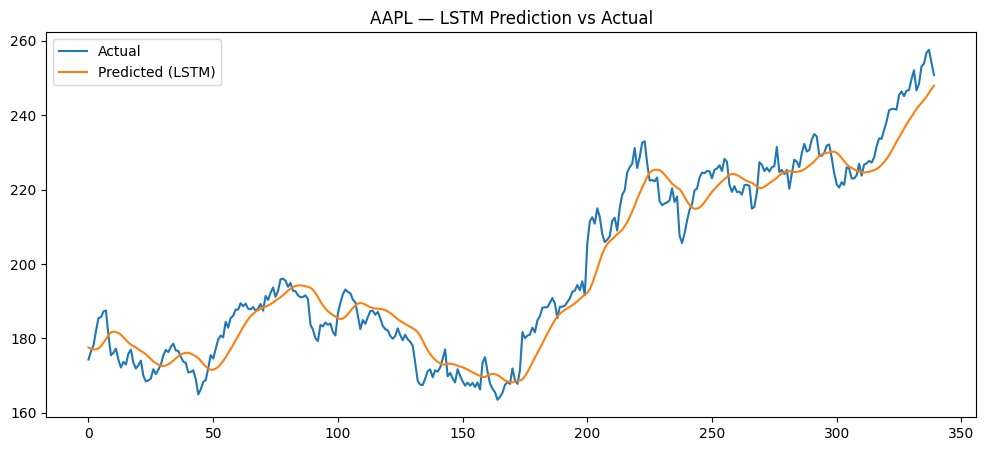

In [40]:
sym = "AAPL"

df = data[sym]
prices = df["Close"].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices)

X, y = create_sequences(scaled_prices, 60)
split = int(len(X) * 0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential([
    LSTM(50, input_shape=(60, 1)),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)
actual = scaler.inverse_transform(y_test)

plt.figure(figsize=(12, 5))
plt.plot(actual, label="Actual")
plt.plot(pred, label="Predicted (LSTM)")
plt.title("AAPL — LSTM Prediction vs Actual")
plt.legend()
plt.show()

In [41]:
df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))

In [42]:
df["target"] = df["log_return"].shift(-1)
df = df.dropna()

In [43]:
df["volatility_14"] = df["log_return"].rolling(14).std()
df["volatility_30"] = df["log_return"].rolling(30).std()

/tmp/ipython-input-194/2161758183.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["volatility_14"] = df["log_return"].rolling(14).std()
/tmp/ipython-input-194/2161758183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["volatility_30"] = df["log_return"].rolling(30).std()


In [44]:
df["momentum_10"] = df["Close"] - df["Close"].shift(10)
df["momentum_20"] = df["Close"] - df["Close"].shift(20)

/tmp/ipython-input-194/1172583594.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["momentum_10"] = df["Close"] - df["Close"].shift(10)
/tmp/ipython-input-194/1172583594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["momentum_20"] = df["Close"] - df["Close"].shift(20)


In [45]:
df["ema_10"] = df["Close"].ewm(span=10).mean()
df["volume_change"] = df["Volume"].pct_change()

/tmp/ipython-input-194/3659126944.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ema_10"] = df["Close"].ewm(span=10).mean()
/tmp/ipython-input-194/3659126944.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["volume_change"] = df["Volume"].pct_change()


In [46]:
df = df.dropna()

In [47]:
features = [
    "log_return",
    "volatility_14",
    "momentum_10",
    "ema_10",
    "volume_change"
]

X = df[features]
y = df["target"]

In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1))

In [50]:
def create_sequences_multivariate(X, y, window_size=60):
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        X_seq.append(X[i-window_size:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences_multivariate(X_scaled, y_scaled, 60)

In [51]:
def split_data(X, y, ratio):
    split = int(len(X)*ratio)
    return X[:split], X[split:], y[:split], y[split:]

# Example 80-20
X_train, X_test, y_train, y_test = split_data(X_seq, y_seq, 0.8)

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_lstm(input_shape):
    model = Sequential()

    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))

    model.add(LSTM(64))
    model.add(Dropout(0.3))

    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    return model

In [53]:
model = build_lstm((60, len(features)))

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - loss: 0.0611 - val_loss: 0.0042
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0118 - val_loss: 0.0034
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0107 - val_loss: 0.0033
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0106 - val_loss: 0.0032
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0100 - val_loss: 0.0032
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0098 - val_loss: 0.0029
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0095 - val_loss: 0.0031
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0091 - val_loss: 0.0029
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0095 - val_loss: 0.0029
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0083 - val_loss: 0.0039
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0097 - val_loss: 0.0030
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0095 - val_l

In [54]:
from tensorflow.keras.layers import GRU

def build_gru(input_shape):
    model = Sequential()

    model.add(GRU(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))

    model.add(GRU(64))
    model.add(Dropout(0.3))

    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    return model

In [55]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step


In [56]:
last_train_price = df["Close"].iloc[len(X_train) + 59]

predicted_prices = []
price = last_train_price

for r in y_pred.flatten():
    price = price * np.exp(r)
    predicted_prices.append(price)

In [57]:
from statsmodels.tsa.arima.model import ARIMA

train_size = int(len(df)*0.8)
train = df["log_return"][:train_size]
test = df["log_return"][train_size:]

model = ARIMA(train, order=(5,0,2))
model_fit = model.fit()

forecast = model_fit.forecast(steps=len(test))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u